<a href="https://colab.research.google.com/github/tperfetti/ML/blob/main/Module_3_Assignment_1_Perfetti.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Ingest (1.0)

#### 1.1: Importing Libraries

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.gridspec as gridspec
from datetime import datetime
from scipy.stats import skew  
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from mlxtend.regressor import StackingCVRegressor
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.linear_model as linear_model
import matplotlib.style as style
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#### 1.2: Crafting Display Options

In [ ]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

#### 1.3: Loading Data

In [ ]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv') 

#### 1.4: Loading Useful Functions

In [ ]:
def get_best_score(grid):
    
    best_score = np.sqrt(-grid.best_score_)
    print(best_score)    
    print(grid.best_params_)
    print(grid.best_estimator_)
    
    return best_score

In [ ]:
def print_cols_large_corr(df, nr_c, targ) :
    corr = df.corr()
    corr_abs = corr.abs()
    print (corr_abs.nlargest(nr_c, targ)[targ])

In [ ]:
def plot_corr_matrix(df, nr_c, targ) :
    
    corr = df.corr()
    corr_abs = corr.abs()
    cols = corr_abs.nlargest(nr_c, targ)[targ].index
    cm = np.corrcoef(df[cols].values.T)

    plt.figure(figsize=(nr_c/1.5, nr_c/1.5))
    sns.set(font_scale=1.25)
    sns.heatmap(cm, linewidths=1.5, annot=True, square=True, 
                fmt='.2f', annot_kws={'size': 10}, 
                yticklabels=cols.values, xticklabels=cols.values
               )
    plt.show()

In [ ]:
def missing_percentage(df):
    """This function takes a DataFrame(df) as input and returns two columns, total missing values and total missing values percentage"""
    total = df.isnull().sum().sort_values(ascending = False)[df.isnull().sum().sort_values(ascending = False) != 0]
    percent = round(df.isnull().sum().sort_values(ascending = False)/len(df)*100,2)[round(df.isnull().sum().sort_values(ascending = False)/len(df)*100,2) != 0]
    return pd.concat([total, percent], axis=1, keys=['Total','Percent'])

In [ ]:
# setting the number of cross validations used in the Model part 
nr_cv = 5
# switch for using log values for SalePrice and features     
use_logvals = 1    
# target used for correlation 
target = 'SalePrice_Log'
# only columns with correlation above this threshold value 
min_val_corr = 0.4    
# switch for dropping columns that are similar to others already used and show a high correlation to these     
drop_similar = 1

#### 1.5: Describing Data

In [ ]:
print("Train data's size: ", train.shape)
train.head()

print("Test data's size: ", test.shape)
test.head()

Train data's size:  (1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Test data's size:  (1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [ ]:
print (f"Train has {train.shape[0]} rows and {train.shape[1]} columns")
print (f"Test has {test.shape[0]} rows and {test.shape[1]} columns")

Train has 1460 rows and 81 columns
Test has 1459 rows and 80 columns


In [ ]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
MSSubClass,1458.0,56.893004,42.329437,20.000000,20.000000,50.000000,70.000000,190.000000
LotFrontage,1199.0,69.797331,23.203458,21.000000,59.000000,69.000000,80.000000,313.000000
LotArea,1458.0,10459.936900,9859.198156,1300.000000,7544.500000,9475.000000,11600.000000,215245.000000
OverallQual,1458.0,6.093964,1.376369,1.000000,5.000000,6.000000,7.000000,10.000000
OverallCond,1458.0,5.576132,1.113359,1.000000,5.000000,5.000000,6.000000,9.000000
YearBuilt,1458.0,1971.218107,30.193754,1872.000000,1954.000000,1972.500000,2000.000000,2010.000000
YearRemodAdd,1458.0,1984.834019,20.641760,1950.000000,1967.000000,1994.000000,2004.000000,2010.000000
MasVnrArea,1450.0,102.753793,179.442156,0.000000,0.000000,0.000000,164.750000,1600.000000
BsmtFinSF1,1458.0,438.827160,432.969094,0.000000,0.000000,382.000000,711.000000,2188.000000
BsmtFinSF2,1458.0,46.613169,161.420729,0.000000,0.000000,0.000000,0.000000,1474.000000


#### 1.6: Checking for Duplicates

In [ ]:
idsUnique = len(set(df.Id))
idsTotal = df.shape[0]
idsDupli = idsTotal - idsUnique
print("There are " + str(idsDupli) + " duplicate IDs for " + str(idsTotal) + " total entries")

There are 0 duplicate IDs for 1460 total entries


## EDA (2.0)

#### 2.1: Handling missing values

In the breakdown below, you will see 19 attributes have missing values. Four attributes (Fence, Alley, MiscFeature, PoolQC) in particular are missing over 70% data. 

In [ ]:
train.isnull().sum()

MSSubClass          0
MSZoning            0
LotFrontage       259
LotArea             0
Street              0
Alley            1367
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType          8
MasVnrArea          8
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           37
BsmtCond           37
BsmtExposure       38
BsmtFinType1       37
BsmtFinSF1          0
BsmtFinType2       38
BsmtFinSF2          0
BsmtUnfSF           0
TotalBsmtSF         0
Heating             0
HeatingQC           0
CentralAir          0
Electrical          1
1stFlrSF            0
2ndFlrSF            0
LowQualFinSF        0
GrLivArea 

<AxesSubplot:>

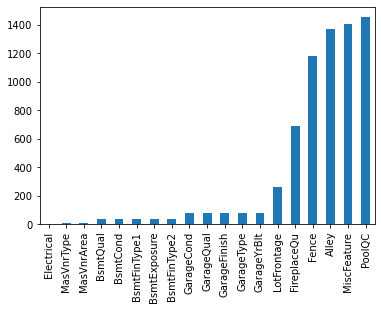

In [ ]:
missing = train.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()

In [ ]:
missing_percentage(train)

,Total,Percent
PoolQC,1453,99.52
MiscFeature,1406,96.30
Alley,1369,93.77
Fence,1179,80.75
FireplaceQu,690,47.26
LotFrontage,259,17.74
GarageYrBlt,81,5.55
GarageCond,81,5.55
GarageType,81,5.55
GarageFinish,81,5.55


In [ ]:
missing_percentage(test)

,Total,Percent
PoolQC,1456,99.79
MiscFeature,1408,96.50
Alley,1352,92.67
Fence,1169,80.12
FireplaceQu,730,50.03
LotFrontage,227,15.56
GarageYrBlt,78,5.35
GarageQual,78,5.35
GarageFinish,78,5.35
GarageCond,78,5.35


#### 2.2: Understanding Sale Price

In the visualizations below, you will see that SalePrice doesn't follow normal distribution.  It is right-skewed and shows peakedness. 

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

Skewness: 1.882876
Kurtosis: 6.536282


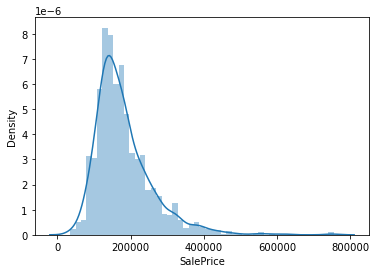

In [ ]:
train['SalePrice'].describe()
sns.distplot(train['SalePrice'])
print("Skewness: %f" % train['SalePrice'].skew())
print("Kurtosis: %f" % train['SalePrice'].kurt())

As we see, the target variable SalePrice is not normally distributed. This can reduce the performance of the ML regression models because some assume normal distribution. Therfore we make a log transformation, the resulting distribution looks much better.

<AxesSubplot:xlabel='SalePrice_Log', ylabel='Density'>

Skewness: 0.121335
Kurtosis: 0.809532


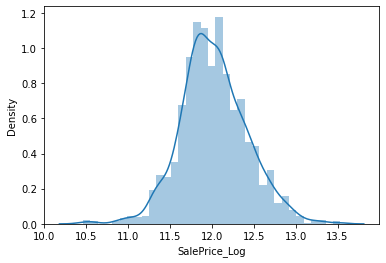

In [ ]:
train['SalePrice_Log'] = np.log(train['SalePrice'])

sns.distplot(train['SalePrice_Log']);
# skewness and kurtosis
print("Skewness: %f" % train['SalePrice_Log'].skew())
print("Kurtosis: %f" % train['SalePrice_Log'].kurt())
# dropping old column
train.drop('SalePrice', axis= 1, inplace=True)

#### 2.3: Understanding Numerical and Categorical Features

In [ ]:
numerical_feats = train.dtypes[train.dtypes != "object"].index
print("Number of Numerical features: ", len(numerical_feats))

categorical_feats = train.dtypes[train.dtypes == "object"].index
print("Number of Categorical features: ", len(categorical_feats))

Number of Numerical features:  38
Number of Categorical features:  43


#### 2.4: Understanding the Relationship with Numerical Values

It appears that there is a linear relationship between Sales Price and Living Area...

<AxesSubplot:xlabel='GrLivArea', ylabel='SalePrice'>

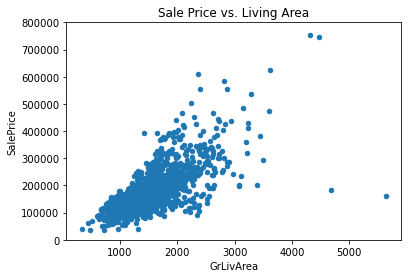

In [ ]:
var = 'GrLivArea'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000))
title = plt.title('Sale Price vs. Living Area')

We can see that basement area may also be good predictive power for the model...

<AxesSubplot:xlabel='TotalBsmtSF', ylabel='SalePrice'>

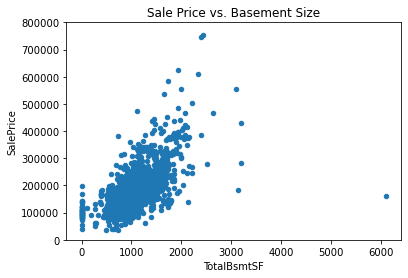

In [ ]:
var = 'TotalBsmtSF'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));
title = plt.title('Sale Price vs. Basement Size')

It appears that on average older houses tended to be cheaper than more recently built homes.

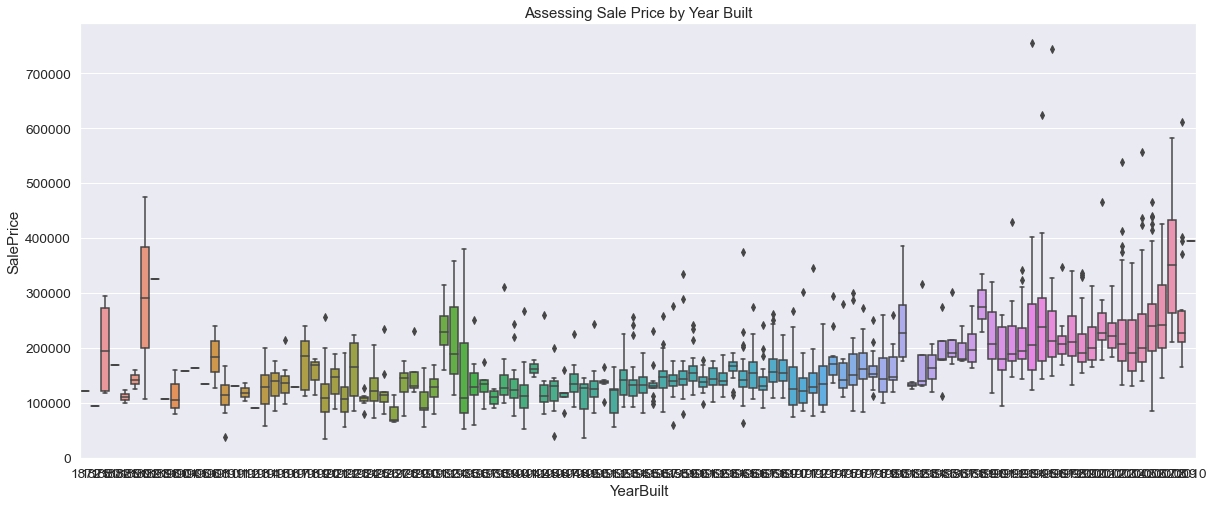

In [ ]:
var = 'YearBuilt'
f, ax = plt.subplots(figsize=(20, 8))
data = pd.concat([train['SalePrice'], train[var]], axis=1)
title = plt.title('Assessing Sale Price by Year Built')
fig = sns.boxplot(x=var, y="SalePrice", data=data)
#plt.xticks(rotation=90)

Houses with garage which can hold 4 cars is generally cheaper than houses with garage that can hold 3...

<Figure size 576x432 with 0 Axes>

<AxesSubplot:xlabel='GarageCars', ylabel='SalePrice'>

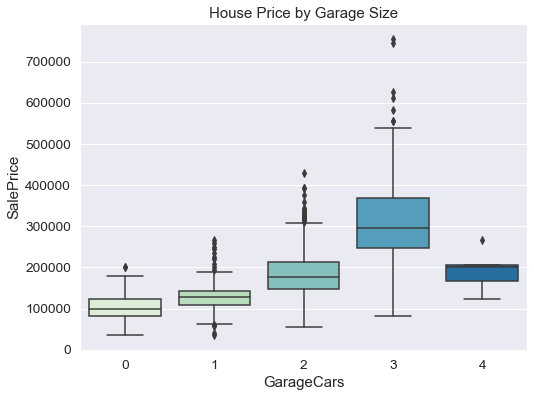

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='GarageCars', y='SalePrice', data=train, palette='GnBu')
title = plt.title('House Price by Garage Size')

#### 2.4: Identifying Outliers

There seems to be a few extreme outliers on the bottom right of the below scatter plot, really large houses that sold for really cheap. We should look to remove these outliers. 

<AxesSubplot:xlabel='GrLivArea', ylabel='SalePrice'>

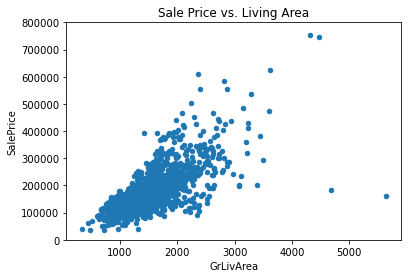

In [ ]:
var = 'GrLivArea'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000))
title = plt.title('Sale Price vs. Living Area')

In [ ]:
train.sort_values(by = 'GrLivArea', ascending = False)[:2]
train = train.drop(train[train['Id'] == 1299].index)
train = train.drop(train[train['Id'] == 524].index)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1298,1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,Corner,Gtl,Edwards,Feedr,Norm,1Fam,2Story,10,5,2008,2008,Hip,ClyTile,Stucco,Stucco,Stone,796.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,5644,Unf,0,466,6110,GasA,Ex,Y,SBrkr,4692,950,0,5642,2,0,2,1,3,1,Ex,12,Typ,3,Gd,Attchd,2008.0,Fin,2,1418,TA,TA,Y,214,292,0,0,0,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000
523,524,60,RL,130.0,40094,Pave,NaN,IR1,Bnk,AllPub,Inside,Gtl,Edwards,PosN,PosN,1Fam,2Story,10,5,2007,2008,Hip,CompShg,CemntBd,CmentBd,Stone,762.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,2260,Unf,0,878,3138,GasA,Ex,Y,SBrkr,3138,1538,0,4676,1,0,3,1,3,1,Ex,11,Typ,1,Gd,BuiltIn,2007.0,Fin,3,884,TA,TA,Y,208,406,0,0,0,0,NaN,NaN,NaN,0,10,2007,New,Partial,184750


#### 2.5: Filling Missing Values

For a few columns there are multiple NaN entries.  In some cases we find this is not missing data. For example, within PoolQC, NaN is not missing data but means no pool, likewise for Fence, FireplaceQu etc.

In [ ]:
# columns where NaN values have meaning
cols_fillna = ['PoolQC','MiscFeature','Alley','Fence','MasVnrType','FireplaceQu',
               'GarageQual','GarageCond','GarageFinish','GarageType', 'Electrical',
               'KitchenQual', 'SaleType', 'Functional', 'Exterior2nd', 'Exterior1st',
               'BsmtExposure','BsmtCond','BsmtQual','BsmtFinType1','BsmtFinType2',
               'MSZoning', 'Utilities']

# replace 'NaN' with 'None' in these columns
for col in cols_fillna:
    train[col].fillna('None',inplace=True)
    test[col].fillna('None',inplace=True)

In [ ]:
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(5)

,Total,Percent
LotFrontage,259,0.177397
GarageYrBlt,81,0.055479
MasVnrArea,8,0.005479
Id,0,0.000000
KitchenAbvGr,0,0.000000


In [ ]:
# fillna with mean for the remaining columns: LotFrontage, GarageYrBlt, MasVnrArea
train.fillna(train.mean(), inplace=True)
test.fillna(test.mean(), inplace=True)

In [ ]:
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(5)

,Total,Percent
Id,0,0.0
CentralAir,0,0.0
GarageYrBlt,0,0.0
GarageType,0,0.0
FireplaceQu,0,0.0


#### 2.6: Assessing Price Segment Trends

In the below visualization, houses are divided in two price groups: cheap (<200000) and expensive (>200000). Then means of quantitative variables are compared. Expensive houses have pools, better overall qual and condition, open porch and increased importance of MasVnrArea.

<AxesSubplot:xlabel='feature', ylabel='difference'>

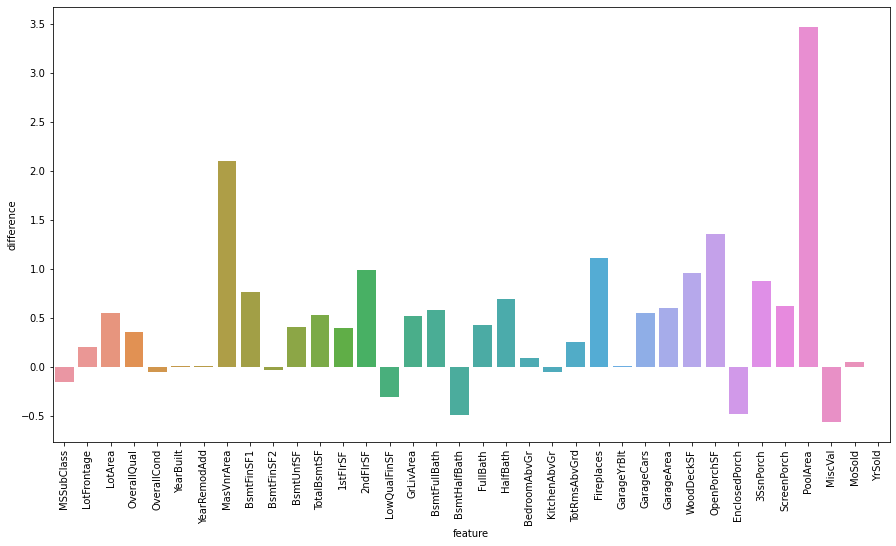

In [ ]:
features = quantitative

standard = train[train['SalePrice'] < 200000]
pricey = train[train['SalePrice'] >= 200000]

diff = pd.DataFrame()
diff['feature'] = features
diff['difference'] = [(pricey[f].fillna(0.).mean() - standard[f].fillna(0.).mean())/(standard[f].fillna(0.).mean())
                      for f in features]

f, ax = plt.subplots(figsize=(15, 8))
sns.barplot(data=diff, x='feature', y='difference')
x=plt.xticks(rotation=90)

#### 2.7: Understanding the Relationship with Categorical Features

Here is quick estimation of influence of categorical variable on SalePrice...

/Users/torrenceperfetti/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:3621: F_onewayBadInputSizesWarning: at least one input has length 0
  warnings.warn(F_onewayBadInputSizesWarning('at least one input '


<AxesSubplot:xlabel='feature', ylabel='disparity'>

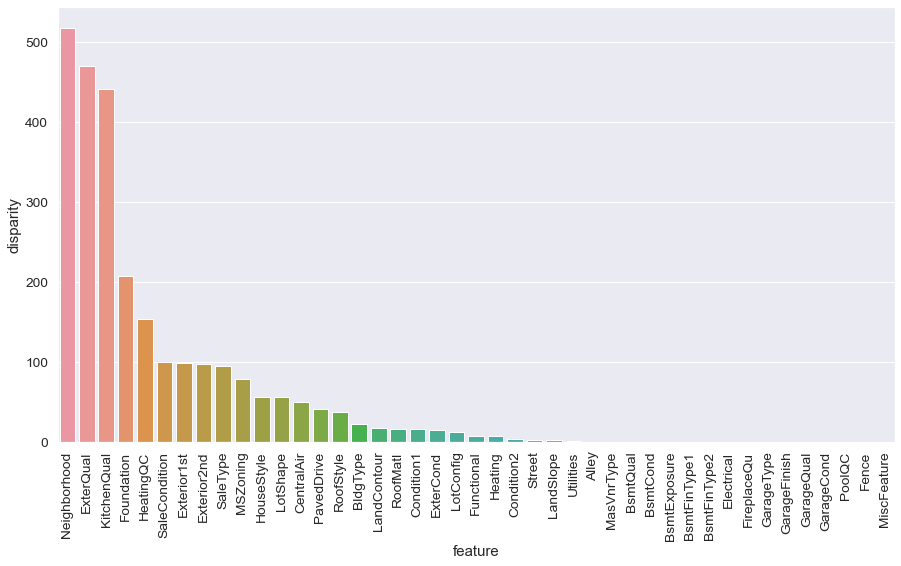

In [ ]:
def anova(frame):
    anv = pd.DataFrame()
    anv['feature'] = qualitative
    pvals = []
    for c in qualitative:
        samples = []
        for cls in frame[c].unique():
            s = frame[frame[c] == cls]['SalePrice'].values
            samples.append(s)
        pval = stats.f_oneway(*samples)[1]
        pvals.append(pval)
    anv['pval'] = pvals
    return anv.sort_values('pval')
f, ax = plt.subplots(figsize=(15, 8))
a = anova(df)
a['disparity'] = np.log(1./a['pval'].values)
sns.barplot(data=a, x='feature', y='disparity')
x=plt.xticks(rotation=90)


There is a big difference in house prices among neighborhood in Ames. The top three most expensive neighborhoods are NridgHt, NoRidge and StoneBr with a median house prices of around $300,000.

(-0.5, 24.5, 0.0, 800000.0)

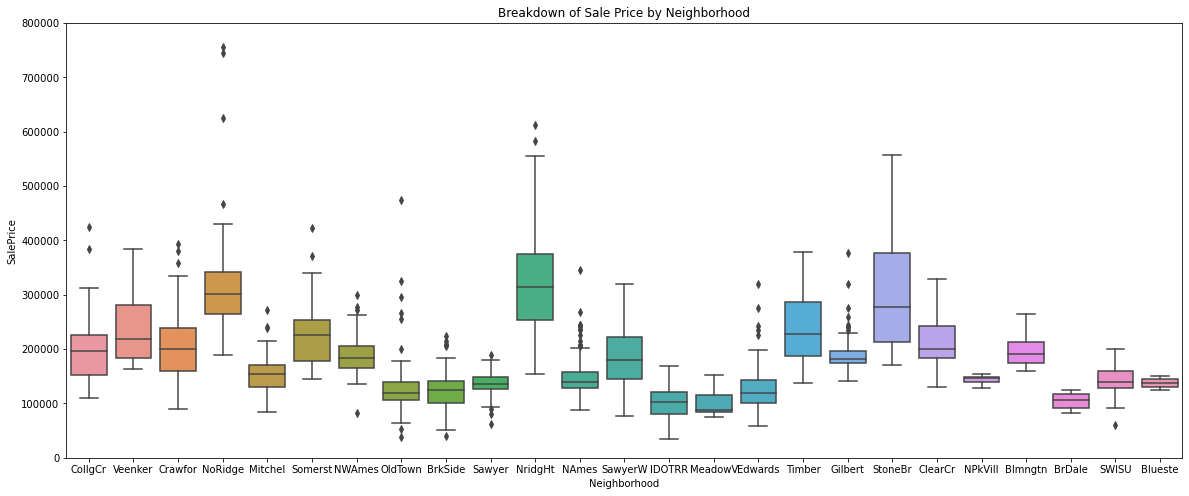

In [ ]:
var = 'Neighborhood'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
f, ax = plt.subplots(figsize=(20, 8))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
title = plt.title('Breakdown of Sale Price by Neighborhood')
fig.axis(ymin=0, ymax=800000)

#### 2.8: Log Transformation

Like the target variable, also some of the feature values are not normally distributed and it is therefore better to use log values in Traing and Test sets. Checking for skewness and kurtosis:

In [ ]:
for col in numerical_feats:
    print('{:15}'.format(col), 
          'Skewness: {:05.2f}'.format(train[col].skew()) , 
          '   ' ,
          'Kurtosis: {:06.2f}'.format(train[col].kurt())  
         )

Id              Skewness: 00.00     Kurtosis: -01.20
MSSubClass      Skewness: 01.41     Kurtosis: 001.58
LotFrontage     Skewness: 02.38     Kurtosis: 021.85
LotArea         Skewness: 12.21     Kurtosis: 203.24
OverallQual     Skewness: 00.22     Kurtosis: 000.10
OverallCond     Skewness: 00.69     Kurtosis: 001.11
YearBuilt       Skewness: -0.61     Kurtosis: -00.44
YearRemodAdd    Skewness: -0.50     Kurtosis: -01.27
MasVnrArea      Skewness: 02.68     Kurtosis: 010.15
BsmtFinSF1      Skewness: 01.69     Kurtosis: 011.12
BsmtFinSF2      Skewness: 04.26     Kurtosis: 020.11
BsmtUnfSF       Skewness: 00.92     Kurtosis: 000.47
TotalBsmtSF     Skewness: 01.52     Kurtosis: 013.25
1stFlrSF        Skewness: 01.38     Kurtosis: 005.75
2ndFlrSF        Skewness: 00.81     Kurtosis: -00.55
LowQualFinSF    Skewness: 09.01     Kurtosis: 083.23
GrLivArea       Skewness: 01.37     Kurtosis: 004.90
BsmtFullBath    Skewness: 00.60     Kurtosis: -00.84
BsmtHalfBath    Skewness: 04.10     Kurtosis: 

<AxesSubplot:xlabel='GrLivArea', ylabel='Density'>

Skewness: 1.366560
Kurtosis: 4.895121


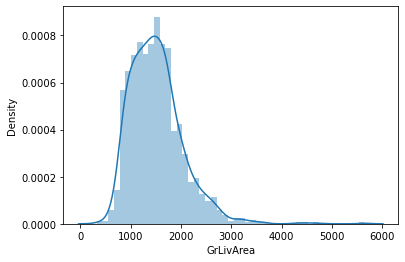

In [ ]:
sns.distplot(train['GrLivArea']);
#skewness and kurtosis
print("Skewness: %f" % train['GrLivArea'].skew())
print("Kurtosis: %f" % train['GrLivArea'].kurt())

<AxesSubplot:xlabel='LotArea', ylabel='Density'>

Skewness: 12.207688
Kurtosis: 203.243271


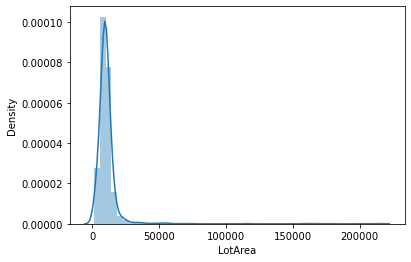

In [ ]:
sns.distplot(train['LotArea']);
#skewness and kurtosis
print("Skewness: %f" % train['LotArea'].skew())
print("Kurtosis: %f" % train['LotArea'].kurt())

In [ ]:
for df in [train, test]:
    df['GrLivArea_Log'] = np.log(df['GrLivArea'])
    df.drop('GrLivArea', inplace= True, axis = 1)
    df['LotArea_Log'] = np.log(df['LotArea'])
    df.drop('LotArea', inplace= True, axis = 1)
    
    
    
numerical_feats = train.dtypes[train.dtypes != "object"].index

<AxesSubplot:xlabel='GrLivArea_Log', ylabel='Density'>

Skewness: -0.006995
Kurtosis: 0.282603


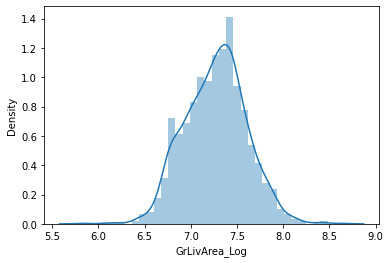

In [ ]:
sns.distplot(train['GrLivArea_Log']);
#skewness and kurtosis
print("Skewness: %f" % train['GrLivArea_Log'].skew())
print("Kurtosis: %f" % train['GrLivArea_Log'].kurt())

<AxesSubplot:xlabel='LotArea_Log', ylabel='Density'>

Skewness: -0.137994
Kurtosis: 4.713358


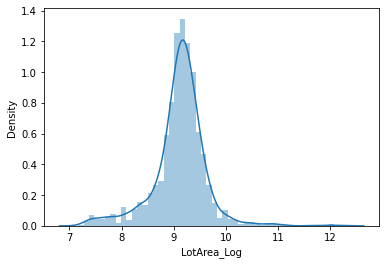

In [ ]:
sns.distplot(train['LotArea_Log']);
#skewness and kurtosis
print("Skewness: %f" % train['LotArea_Log'].skew())
print("Kurtosis: %f" % train['LotArea_Log'].kurt())

#### 2.9: Relation of Features to Target (SalePrice_log)

Below are plots of relation to target for all numerical features:

<AxesSubplot:xlabel='MSSubClass', ylabel='SalePrice_Log'>

Text(0.5, 1.0, 'r = -0.07      p = 0.00')

<AxesSubplot:xlabel='LotFrontage', ylabel='SalePrice_Log'>

Text(0.5, 1.0, 'r = 0.34      p = 0.00')

<AxesSubplot:xlabel='OverallQual', ylabel='SalePrice_Log'>

Text(0.5, 1.0, 'r = 0.82      p = 0.00')

<AxesSubplot:xlabel='OverallCond', ylabel='SalePrice_Log'>

Text(0.5, 1.0, 'r = -0.04      p = 0.16')

<AxesSubplot:xlabel='YearBuilt', ylabel='SalePrice_Log'>

Text(0.5, 1.0, 'r = 0.59      p = 0.00')

<AxesSubplot:xlabel='YearRemodAdd', ylabel='SalePrice_Log'>

Text(0.5, 1.0, 'r = 0.57      p = 0.00')

<AxesSubplot:xlabel='MasVnrArea', ylabel='SalePrice_Log'>

Text(0.5, 1.0, 'r = 0.43      p = 0.00')

<AxesSubplot:xlabel='BsmtFinSF1', ylabel='SalePrice_Log'>

Text(0.5, 1.0, 'r = 0.37      p = 0.00')

<AxesSubplot:xlabel='BsmtFinSF2', ylabel='SalePrice_Log'>

Text(0.5, 1.0, 'r = 0.00      p = 0.85')

<AxesSubplot:xlabel='BsmtUnfSF', ylabel='SalePrice_Log'>

Text(0.5, 1.0, 'r = 0.22      p = 0.00')

<AxesSubplot:xlabel='TotalBsmtSF', ylabel='SalePrice_Log'>

Text(0.5, 1.0, 'r = 0.61      p = 0.00')

<AxesSubplot:xlabel='1stFlrSF', ylabel='SalePrice_Log'>

Text(0.5, 1.0, 'r = 0.60      p = 0.00')

<AxesSubplot:xlabel='2ndFlrSF', ylabel='SalePrice_Log'>

Text(0.5, 1.0, 'r = 0.32      p = 0.00')

<AxesSubplot:xlabel='LowQualFinSF', ylabel='SalePrice_Log'>

Text(0.5, 1.0, 'r = -0.04      p = 0.15')

<AxesSubplot:xlabel='BsmtFullBath', ylabel='SalePrice_Log'>

Text(0.5, 1.0, 'r = 0.24      p = 0.00')

<AxesSubplot:xlabel='BsmtHalfBath', ylabel='SalePrice_Log'>

Text(0.5, 1.0, 'r = -0.01      p = 0.84')

<AxesSubplot:xlabel='FullBath', ylabel='SalePrice_Log'>

Text(0.5, 1.0, 'r = 0.59      p = 0.00')

<AxesSubplot:xlabel='HalfBath', ylabel='SalePrice_Log'>

Text(0.5, 1.0, 'r = 0.31      p = 0.00')

<AxesSubplot:xlabel='BedroomAbvGr', ylabel='SalePrice_Log'>

Text(0.5, 1.0, 'r = 0.21      p = 0.00')

<AxesSubplot:xlabel='KitchenAbvGr', ylabel='SalePrice_Log'>

Text(0.5, 1.0, 'r = -0.15      p = 0.00')

<AxesSubplot:xlabel='TotRmsAbvGrd', ylabel='SalePrice_Log'>

Text(0.5, 1.0, 'r = 0.53      p = 0.00')

<AxesSubplot:xlabel='Fireplaces', ylabel='SalePrice_Log'>

Text(0.5, 1.0, 'r = 0.49      p = 0.00')

<AxesSubplot:xlabel='GarageYrBlt', ylabel='SalePrice_Log'>

Text(0.5, 1.0, 'r = 0.50      p = 0.00')

<AxesSubplot:xlabel='GarageCars', ylabel='SalePrice_Log'>

Text(0.5, 1.0, 'r = 0.68      p = 0.00')

<AxesSubplot:xlabel='GarageArea', ylabel='SalePrice_Log'>

Text(0.5, 1.0, 'r = 0.65      p = 0.00')

<AxesSubplot:xlabel='WoodDeckSF', ylabel='SalePrice_Log'>

Text(0.5, 1.0, 'r = 0.33      p = 0.00')

<AxesSubplot:xlabel='OpenPorchSF', ylabel='SalePrice_Log'>

Text(0.5, 1.0, 'r = 0.32      p = 0.00')

<AxesSubplot:xlabel='EnclosedPorch', ylabel='SalePrice_Log'>

Text(0.5, 1.0, 'r = -0.15      p = 0.00')

<AxesSubplot:xlabel='3SsnPorch', ylabel='SalePrice_Log'>

Text(0.5, 1.0, 'r = 0.05      p = 0.04')

<AxesSubplot:xlabel='ScreenPorch', ylabel='SalePrice_Log'>

Text(0.5, 1.0, 'r = 0.12      p = 0.00')

<AxesSubplot:xlabel='PoolArea', ylabel='SalePrice_Log'>

Text(0.5, 1.0, 'r = 0.07      p = 0.01')

<AxesSubplot:xlabel='MiscVal', ylabel='SalePrice_Log'>

Text(0.5, 1.0, 'r = -0.02      p = 0.44')

<AxesSubplot:xlabel='MoSold', ylabel='SalePrice_Log'>

Text(0.5, 1.0, 'r = 0.06      p = 0.03')

<AxesSubplot:xlabel='YrSold', ylabel='SalePrice_Log'>

Text(0.5, 1.0, 'r = -0.04      p = 0.15')

<AxesSubplot:xlabel='GrLivArea_Log', ylabel='SalePrice_Log'>

Text(0.5, 1.0, 'r = 0.73      p = 0.00')

<AxesSubplot:xlabel='LotArea_Log', ylabel='SalePrice_Log'>

Text(0.5, 1.0, 'r = 0.40      p = 0.00')

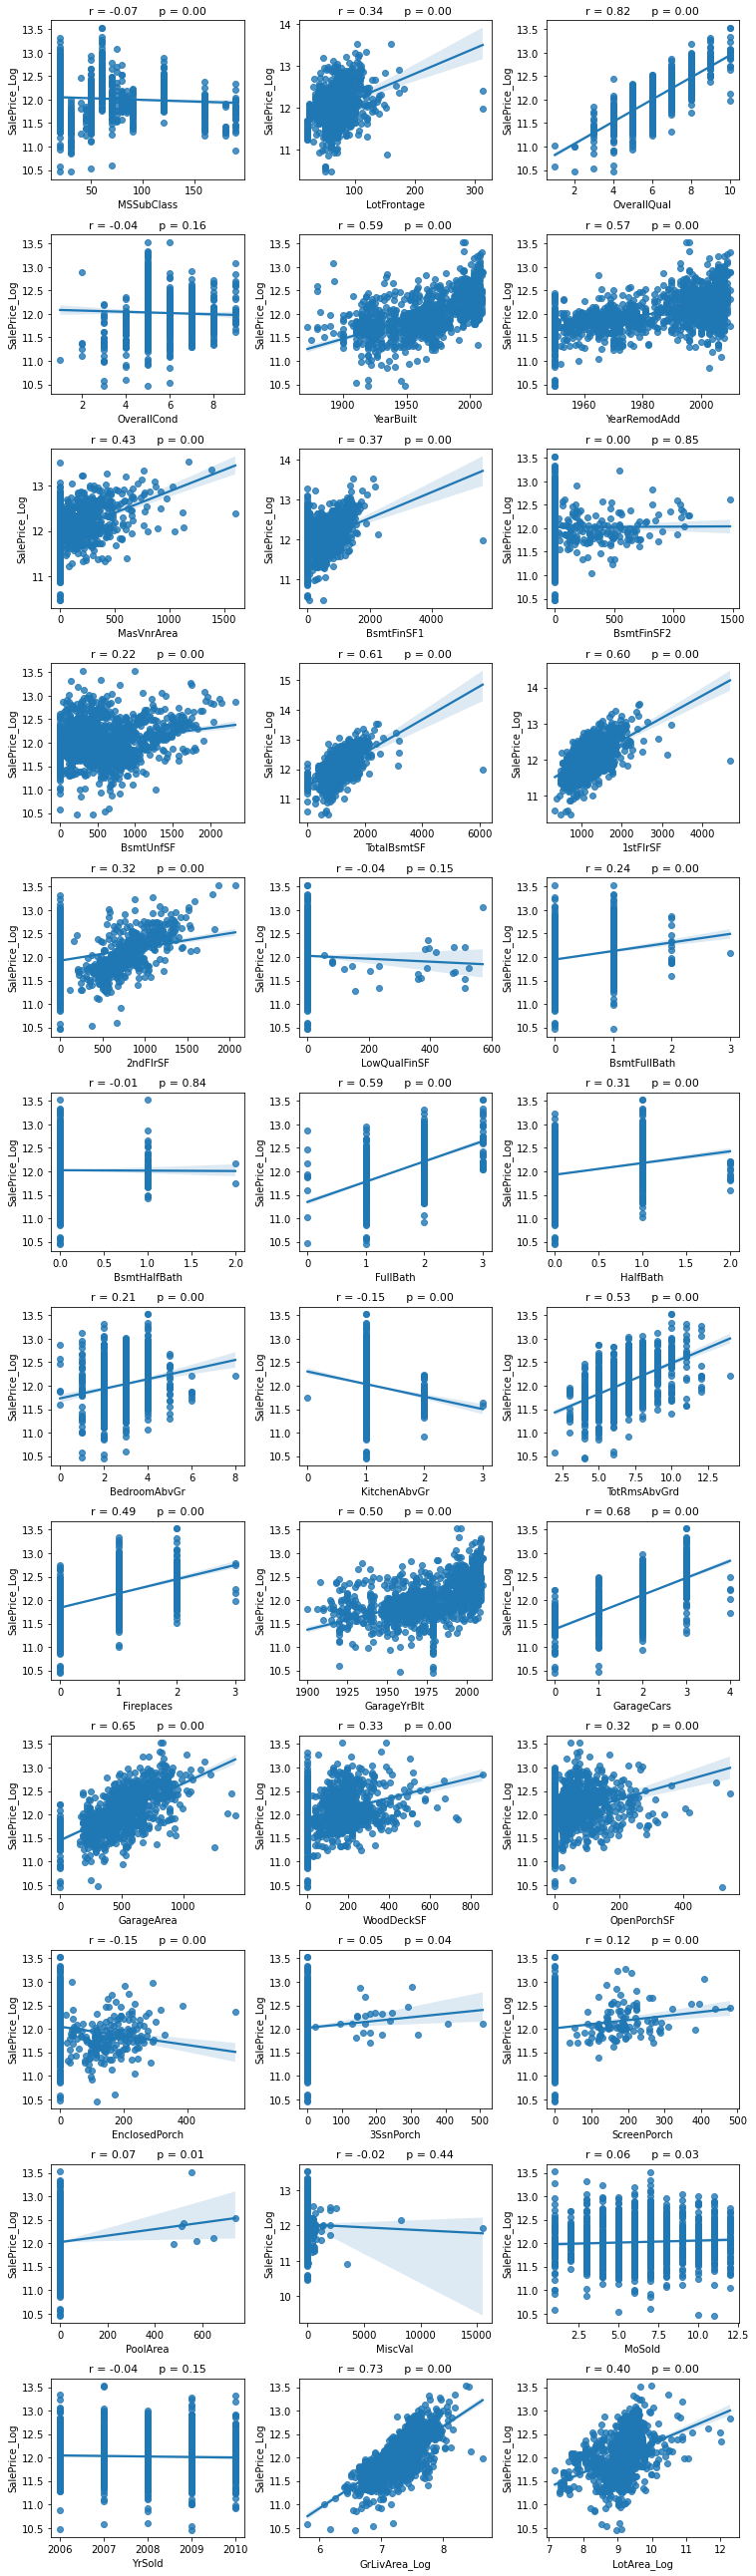

In [ ]:
nr_rows = 12
nr_cols = 3

fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5,nr_rows*3))

li_num_feats = list(numerical_feats)
li_not_plot = ['Id', 'SalePrice', 'SalePrice_Log']
li_plot_num_feats = [c for c in list(numerical_feats) if c not in li_not_plot]

for r in range(0,nr_rows):
    for c in range(0,nr_cols):  
        i = r*nr_cols+c
        if i < len(li_plot_num_feats):
            sns.regplot(train[li_plot_num_feats[i]], train[target], ax = axs[r][c])
            stp = stats.pearsonr(train[li_plot_num_feats[i]], train[target])
            #axs[r][c].text(0.4,0.9,"title",fontsize=7)
            str_title = "r = " + "{0:.2f}".format(stp[0]) + "      " "p = " + "{0:.2f}".format(stp[1])
            axs[r][c].set_title(str_title,fontsize=11)
            
plt.tight_layout()    
plt.show()  

#### 2.10: Removing Outliers

In [ ]:
train = train.drop(
    train[(train['OverallQual']==10) & (train['SalePrice_Log']<12.3)].index)

In [ ]:
train = train.drop(
    train[(train['GrLivArea_Log']>8.3) & (train['SalePrice_Log']<12.5)].index)

#### 2.11: Identifying Strong Correlation

In [ ]:
corr = train.corr()
corr_abs = corr.abs()

nr_num_cols = len(numerical_feats)
ser_corr = corr_abs.nlargest(nr_num_cols, target)[target]

cols_abv_corr_limit = list(ser_corr[ser_corr.values > min_val_corr].index)
cols_bel_corr_limit = list(ser_corr[ser_corr.values <= min_val_corr].index)

Listing of numerical features and their correlation coefficient to target...

In [ ]:
print(ser_corr)
print("List of numerical features with r above min_val_corr :")
print(cols_abv_corr_limit)
print("List of numerical features with r below min_val_corr :")
print(cols_bel_corr_limit)

SalePrice_Log    1.000000
OverallQual      0.821404
GrLivArea_Log    0.737427
GarageCars       0.681033
GarageArea       0.656128
TotalBsmtSF      0.647563
1stFlrSF         0.620500
FullBath         0.595899
YearBuilt        0.587043
YearRemodAdd     0.565992
TotRmsAbvGrd     0.537702
GarageYrBlt      0.500842
Fireplaces       0.491998
MasVnrArea       0.433353
LotArea_Log      0.402814
BsmtFinSF1       0.392283
LotFrontage      0.352432
WoodDeckSF       0.334250
OpenPorchSF      0.325215
2ndFlrSF         0.319953
HalfBath         0.314186
BsmtFullBath     0.237099
BsmtUnfSF        0.221892
BedroomAbvGr     0.209036
EnclosedPorch    0.149029
KitchenAbvGr     0.147534
ScreenPorch      0.121245
PoolArea         0.074338
MSSubClass       0.073969
MoSold           0.057064
3SsnPorch        0.054914
LowQualFinSF     0.037951
YrSold           0.037151
OverallCond      0.036821
MiscVal          0.020012
Id               0.017774
BsmtHalfBath     0.005124
BsmtFinSF2       0.004863
Name: SalePr

Understanding relation to SalePrice for all categorical features....

<AxesSubplot:xlabel='MSZoning', ylabel='SalePrice_Log'>

<AxesSubplot:xlabel='Street', ylabel='SalePrice_Log'>

<AxesSubplot:xlabel='Alley', ylabel='SalePrice_Log'>

<AxesSubplot:xlabel='LotShape', ylabel='SalePrice_Log'>

<AxesSubplot:xlabel='LandContour', ylabel='SalePrice_Log'>

<AxesSubplot:xlabel='Utilities', ylabel='SalePrice_Log'>

<AxesSubplot:xlabel='LotConfig', ylabel='SalePrice_Log'>

<AxesSubplot:xlabel='LandSlope', ylabel='SalePrice_Log'>

<AxesSubplot:xlabel='Neighborhood', ylabel='SalePrice_Log'>

<AxesSubplot:xlabel='Condition1', ylabel='SalePrice_Log'>

<AxesSubplot:xlabel='Condition2', ylabel='SalePrice_Log'>

<AxesSubplot:xlabel='BldgType', ylabel='SalePrice_Log'>

<AxesSubplot:xlabel='HouseStyle', ylabel='SalePrice_Log'>

<AxesSubplot:xlabel='RoofStyle', ylabel='SalePrice_Log'>

<AxesSubplot:xlabel='RoofMatl', ylabel='SalePrice_Log'>

<AxesSubplot:xlabel='Exterior1st', ylabel='SalePrice_Log'>

<AxesSubplot:xlabel='Exterior2nd', ylabel='SalePrice_Log'>

<AxesSubplot:xlabel='MasVnrType', ylabel='SalePrice_Log'>

<AxesSubplot:xlabel='ExterQual', ylabel='SalePrice_Log'>

<AxesSubplot:xlabel='ExterCond', ylabel='SalePrice_Log'>

<AxesSubplot:xlabel='Foundation', ylabel='SalePrice_Log'>

<AxesSubplot:xlabel='BsmtQual', ylabel='SalePrice_Log'>

<AxesSubplot:xlabel='BsmtCond', ylabel='SalePrice_Log'>

<AxesSubplot:xlabel='BsmtExposure', ylabel='SalePrice_Log'>

<AxesSubplot:xlabel='BsmtFinType1', ylabel='SalePrice_Log'>

<AxesSubplot:xlabel='BsmtFinType2', ylabel='SalePrice_Log'>

<AxesSubplot:xlabel='Heating', ylabel='SalePrice_Log'>

<AxesSubplot:xlabel='HeatingQC', ylabel='SalePrice_Log'>

<AxesSubplot:xlabel='CentralAir', ylabel='SalePrice_Log'>

<AxesSubplot:xlabel='Electrical', ylabel='SalePrice_Log'>

<AxesSubplot:xlabel='KitchenQual', ylabel='SalePrice_Log'>

<AxesSubplot:xlabel='Functional', ylabel='SalePrice_Log'>

<AxesSubplot:xlabel='FireplaceQu', ylabel='SalePrice_Log'>

<AxesSubplot:xlabel='GarageType', ylabel='SalePrice_Log'>

<AxesSubplot:xlabel='GarageFinish', ylabel='SalePrice_Log'>

<AxesSubplot:xlabel='GarageQual', ylabel='SalePrice_Log'>

<AxesSubplot:xlabel='GarageCond', ylabel='SalePrice_Log'>

<AxesSubplot:xlabel='PavedDrive', ylabel='SalePrice_Log'>

<AxesSubplot:xlabel='PoolQC', ylabel='SalePrice_Log'>

<AxesSubplot:xlabel='Fence', ylabel='SalePrice_Log'>

<AxesSubplot:xlabel='MiscFeature', ylabel='SalePrice_Log'>

<AxesSubplot:xlabel='SaleType', ylabel='SalePrice_Log'>

<AxesSubplot:xlabel='SaleCondition', ylabel='SalePrice_Log'>

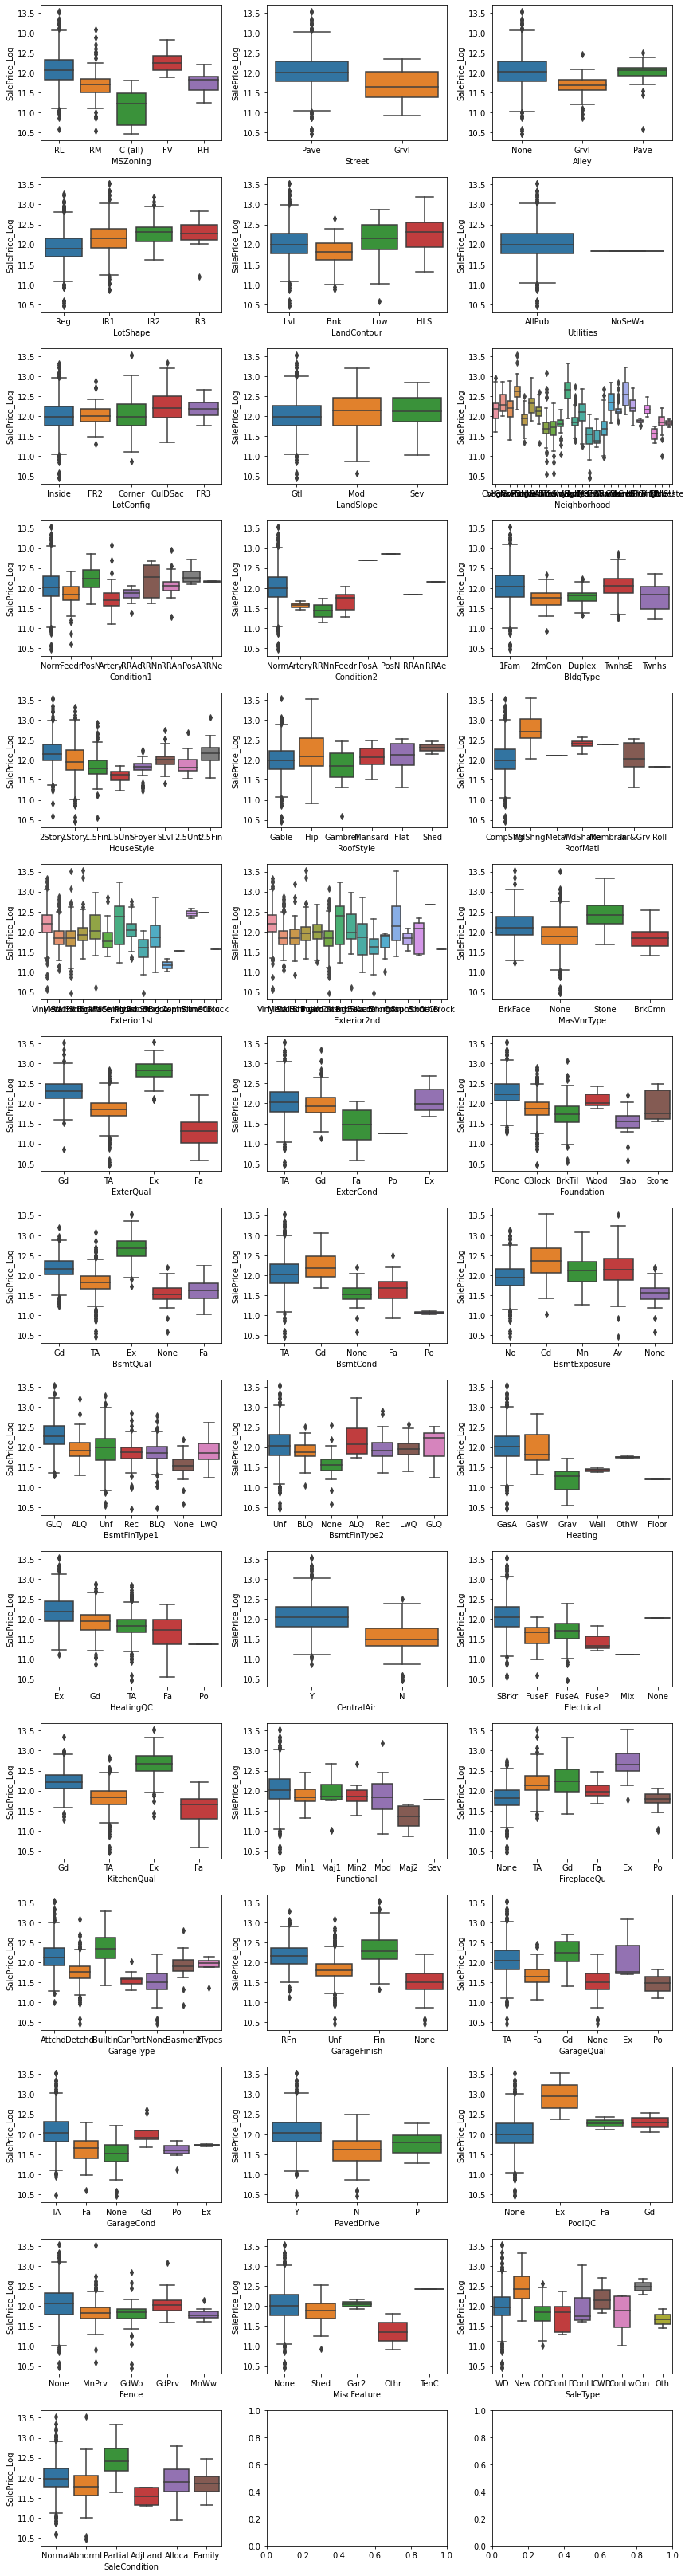

In [ ]:
li_cat_feats = list(categorical_feats)
nr_rows = 15
nr_cols = 3

fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*4,nr_rows*3))

for r in range(0,nr_rows):
    for c in range(0,nr_cols):  
        i = r*nr_cols+c
        if i < len(li_cat_feats):
            sns.boxplot(x=li_cat_feats[i], y=target, data=train, ax = axs[r][c])
    
plt.tight_layout()    
plt.show()  

#### 2.12: Understanding Correlations 

In [ ]:
catg_strong_corr = [ 'MSZoning', 'Neighborhood', 'Condition2', 'MasVnrType', 'ExterQual', 
                     'BsmtQual','CentralAir', 'Electrical', 'KitchenQual', 'SaleType']

catg_weak_corr = ['Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 
                  'LandSlope', 'Condition1',  'BldgType', 'HouseStyle', 'RoofStyle', 
                  'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterCond', 'Foundation', 
                  'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 
                  'HeatingQC', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 
                  'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 
                  'SaleCondition' ]

In [ ]:
nr_feats = len(cols_abv_corr_limit)

Of those features with the largest correlation to SalePrice, some also are correlated strongly to each other. To avoid failures of the ML regression models due to multicollinearity, we will drop these pieces.

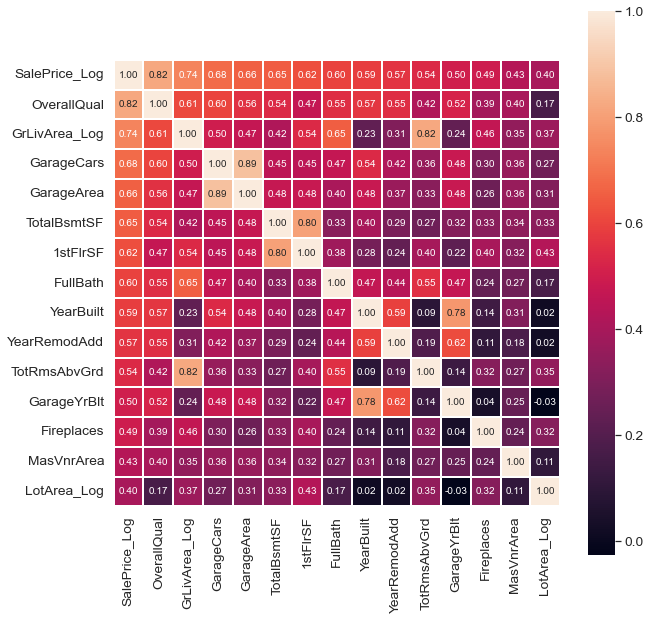

In [ ]:
plot_corr_matrix(train, nr_feats, target)

#### 2.12.1: Dropping Weak Correlations 

In [ ]:
id_test = test['Id']

to_drop_num  = cols_bel_corr_limit
to_drop_catg = catg_weak_corr

cols_to_drop = ['Id'] + to_drop_num + to_drop_catg 

for df in [train, test]:
    df.drop(cols_to_drop, inplace= True, axis = 1)

#### 2.12.2: Converting Categorical to Numerical

For those categorcial features where the EDA with boxplots seem to show a strong dependence of the SalePrice on the category, we transform the columns to numerical. To investigate the relation of the categories to SalePrice in more detail, we make violinplots for these features.

<AxesSubplot:xlabel='MSZoning', ylabel='SalePrice_Log'>

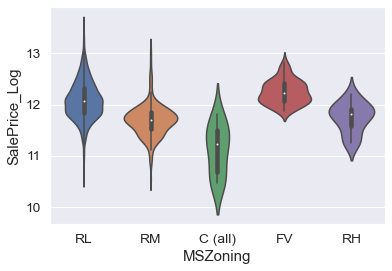

<AxesSubplot:xlabel='Condition2', ylabel='SalePrice_Log'>

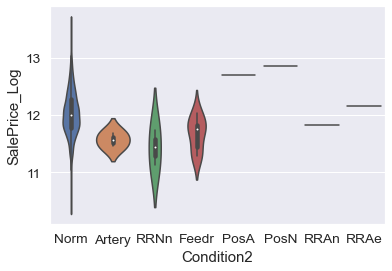

<AxesSubplot:xlabel='MasVnrType', ylabel='SalePrice_Log'>

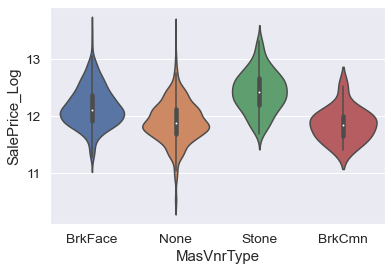

<AxesSubplot:xlabel='ExterQual', ylabel='SalePrice_Log'>

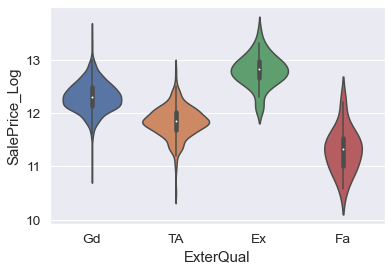

<AxesSubplot:xlabel='BsmtQual', ylabel='SalePrice_Log'>

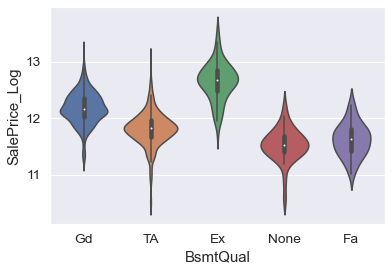

<AxesSubplot:xlabel='CentralAir', ylabel='SalePrice_Log'>

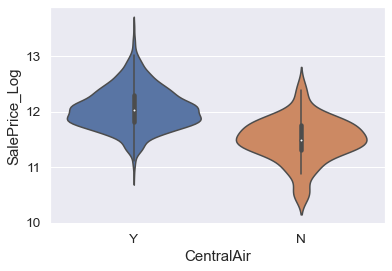

<AxesSubplot:xlabel='Electrical', ylabel='SalePrice_Log'>

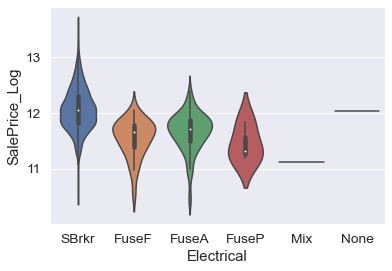

<AxesSubplot:xlabel='KitchenQual', ylabel='SalePrice_Log'>

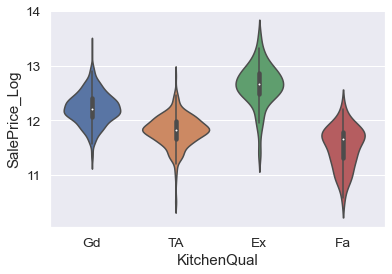

<AxesSubplot:xlabel='SaleType', ylabel='SalePrice_Log'>

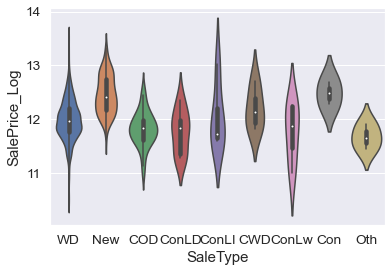

In [ ]:
catg_list = catg_strong_corr.copy()
catg_list.remove('Neighborhood')

for catg in catg_list :
    #sns.catplot(x=catg, y=target, data=df_train, kind='boxen')
    sns.violinplot(x=catg, y=target, data=train)
    plt.show()
    #sns.boxenplot(x=catg, y=target, data=df_train)
    #bp = df_train.boxplot(column=[target], by=catg)

In [ ]:
for catg in catg_list :
    g = train.groupby(catg)[target].mean()
    print(g)

MSZoning
C (all)    11.118259
FV         12.246616
RH         11.749840
RL         12.085939
RM         11.692893
Name: SalePrice_Log, dtype: float64
Condition2
Artery    11.570036
Feedr     11.670631
Norm      12.025925
PosA      12.691580
PosN      12.860999
RRAe      12.154779
RRAn      11.827043
RRNn      11.435329
Name: SalePrice_Log, dtype: float64
MasVnrType
BrkCmn     11.853239
BrkFace    12.163630
None       11.896884
Stone      12.431016
Name: SalePrice_Log, dtype: float64
ExterQual
Ex    12.792412
Fa    11.304541
Gd    12.311282
TA    11.837985
Name: SalePrice_Log, dtype: float64
BsmtQual
Ex      12.650235
Fa      11.617600
Gd      12.179882
None    11.529680
TA      11.810855
Name: SalePrice_Log, dtype: float64
CentralAir
N    11.491858
Y    12.061099
Name: SalePrice_Log, dtype: float64
Electrical
FuseA    11.660315
FuseF    11.539624
FuseP    11.446808
Mix      11.112448
None     12.028739
SBrkr    12.061474
Name: SalePrice_Log, dtype: float64
KitchenQual
Ex    12.645425
F

In [ ]:
# 'MSZoning'
msz_catg2 = ['RM', 'RH']
msz_catg3 = ['RL', 'FV'] 


# Neighborhood
nbhd_catg2 = ['Blmngtn', 'ClearCr', 'CollgCr', 'Crawfor', 'Gilbert', 'NWAmes', 'Somerst', 'Timber', 'Veenker']
nbhd_catg3 = ['NoRidge', 'NridgHt', 'StoneBr']

# Condition2
cond2_catg2 = ['Norm', 'RRAe']
cond2_catg3 = ['PosA', 'PosN'] 

# SaleType
SlTy_catg1 = ['Oth']
SlTy_catg3 = ['CWD']
SlTy_catg4 = ['New', 'Con']

In [ ]:
for df in [train, test]:
    
    df['MSZ_num'] = 1  
    df.loc[(df['MSZoning'].isin(msz_catg2) ), 'MSZ_num'] = 2    
    df.loc[(df['MSZoning'].isin(msz_catg3) ), 'MSZ_num'] = 3        
    
    df['NbHd_num'] = 1       
    df.loc[(df['Neighborhood'].isin(nbhd_catg2) ), 'NbHd_num'] = 2    
    df.loc[(df['Neighborhood'].isin(nbhd_catg3) ), 'NbHd_num'] = 3    

    df['Cond2_num'] = 1       
    df.loc[(df['Condition2'].isin(cond2_catg2) ), 'Cond2_num'] = 2    
    df.loc[(df['Condition2'].isin(cond2_catg3) ), 'Cond2_num'] = 3    
    
    df['Mas_num'] = 1       
    df.loc[(df['MasVnrType'] == 'Stone' ), 'Mas_num'] = 2 
    
    df['ExtQ_num'] = 1       
    df.loc[(df['ExterQual'] == 'TA' ), 'ExtQ_num'] = 2     
    df.loc[(df['ExterQual'] == 'Gd' ), 'ExtQ_num'] = 3     
    df.loc[(df['ExterQual'] == 'Ex' ), 'ExtQ_num'] = 4     
   
    df['BsQ_num'] = 1          
    df.loc[(df['BsmtQual'] == 'Gd' ), 'BsQ_num'] = 2     
    df.loc[(df['BsmtQual'] == 'Ex' ), 'BsQ_num'] = 3     
 
    df['CA_num'] = 0          
    df.loc[(df['CentralAir'] == 'Y' ), 'CA_num'] = 1    

    df['Elc_num'] = 1       
    df.loc[(df['Electrical'] == 'SBrkr' ), 'Elc_num'] = 2 


    df['KiQ_num'] = 1       
    df.loc[(df['KitchenQual'] == 'TA' ), 'KiQ_num'] = 2     
    df.loc[(df['KitchenQual'] == 'Gd' ), 'KiQ_num'] = 3     
    df.loc[(df['KitchenQual'] == 'Ex' ), 'KiQ_num'] = 4      
    
    df['SlTy_num'] = 2       
    df.loc[(df['SaleType'].isin(SlTy_catg1) ), 'SlTy_num'] = 1  
    df.loc[(df['SaleType'].isin(SlTy_catg3) ), 'SlTy_num'] = 3  
    df.loc[(df['SaleType'].isin(SlTy_catg4) ), 'SlTy_num'] = 4

#### 2.12.3: Checking Correlation with New Numerical Columns

There are few columns with quite large correlation to SalePrice (NbHd_num, ExtQ_num, BsQ_num, KiQ_num). These will probably be useful for optimal performance of the Regression Model.

<AxesSubplot:xlabel='MSZ_num', ylabel='SalePrice_Log'>

Text(0.5, 1.0, 'r = 0.41      p = 0.00')

<AxesSubplot:xlabel='NbHd_num', ylabel='SalePrice_Log'>

Text(0.5, 1.0, 'r = 0.70      p = 0.00')

<AxesSubplot:xlabel='Cond2_num', ylabel='SalePrice_Log'>

Text(0.5, 1.0, 'r = 0.11      p = 0.00')

<AxesSubplot:xlabel='Mas_num', ylabel='SalePrice_Log'>

Text(0.5, 1.0, 'r = 0.31      p = 0.00')

<AxesSubplot:xlabel='ExtQ_num', ylabel='SalePrice_Log'>

Text(0.5, 1.0, 'r = 0.68      p = 0.00')

<AxesSubplot:xlabel='BsQ_num', ylabel='SalePrice_Log'>

Text(0.5, 1.0, 'r = 0.66      p = 0.00')

<AxesSubplot:xlabel='CA_num', ylabel='SalePrice_Log'>

Text(0.5, 1.0, 'r = 0.35      p = 0.00')

<AxesSubplot:xlabel='Elc_num', ylabel='SalePrice_Log'>

Text(0.5, 1.0, 'r = 0.30      p = 0.00')

<AxesSubplot:xlabel='KiQ_num', ylabel='SalePrice_Log'>

Text(0.5, 1.0, 'r = 0.67      p = 0.00')

<AxesSubplot:xlabel='SlTy_num', ylabel='SalePrice_Log'>

Text(0.5, 1.0, 'r = 0.34      p = 0.00')

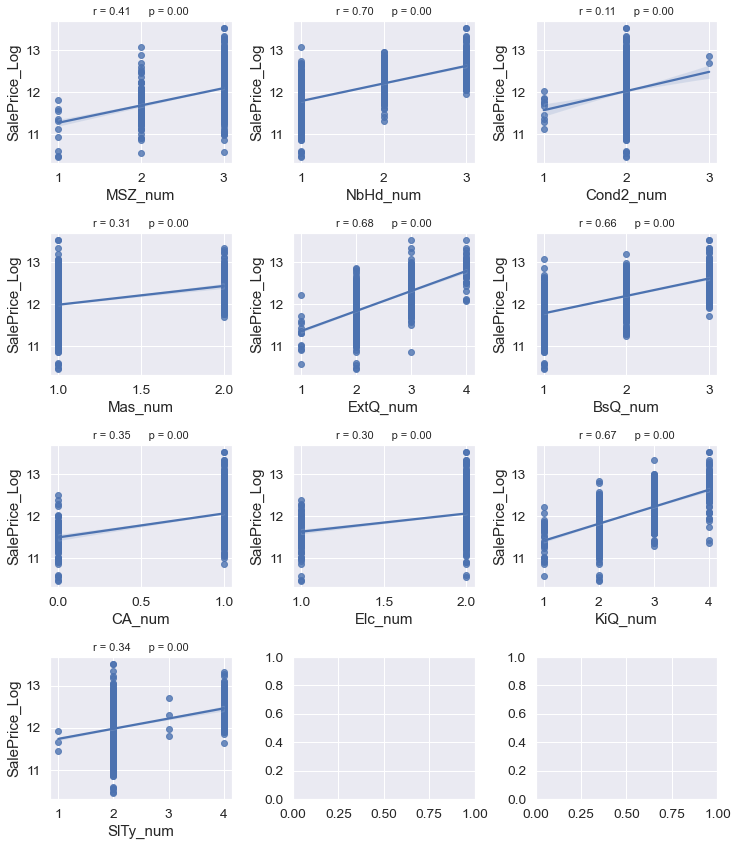

In [ ]:
new_col_num = ['MSZ_num', 'NbHd_num', 'Cond2_num', 'Mas_num', 'ExtQ_num', 'BsQ_num', 'CA_num', 'Elc_num', 'KiQ_num', 'SlTy_num']

nr_rows = 4
nr_cols = 3

fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5,nr_rows*3))

for r in range(0,nr_rows):
    for c in range(0,nr_cols):  
        i = r*nr_cols+c
        if i < len(new_col_num):
            sns.regplot(train[new_col_num[i]], train[target], ax = axs[r][c])
            stp = stats.pearsonr(train[new_col_num[i]], train[target])
            str_title = "r = " + "{0:.2f}".format(stp[0]) + "      " "p = " + "{0:.2f}".format(stp[1])
            axs[r][c].set_title(str_title,fontsize=11)
            
plt.tight_layout()    
plt.show()

#### 2.12.4: Dropping Columns with Weak Correlation

In [ ]:
catg_cols_to_drop = ['Neighborhood' , 'Condition2', 'MasVnrType', 'ExterQual', 'BsmtQual','CentralAir', 'Electrical', 'KitchenQual', 'SaleType']

corr1 = train.corr()
corr_abs_1 = corr1.abs()

nr_all_cols = len(train)
ser_corr_1 = corr_abs_1.nlargest(nr_all_cols, target)[target]

print(ser_corr_1)
cols_bel_corr_limit_1 = list(ser_corr_1[ser_corr_1.values <= min_val_corr].index)


for df in [train, test] :
    df.drop(catg_cols_to_drop, inplace= True, axis = 1)
    df.drop(cols_bel_corr_limit_1, inplace= True, axis = 1)

SalePrice_Log    1.000000
OverallQual      0.821404
GrLivArea_Log    0.737427
NbHd_num         0.696962
ExtQ_num         0.682225
GarageCars       0.681033
KiQ_num          0.669989
BsQ_num          0.661286
GarageArea       0.656128
TotalBsmtSF      0.647563
1stFlrSF         0.620500
FullBath         0.595899
YearBuilt        0.587043
YearRemodAdd     0.565992
TotRmsAbvGrd     0.537702
GarageYrBlt      0.500842
Fireplaces       0.491998
MasVnrArea       0.433353
MSZ_num          0.409423
LotArea_Log      0.402814
CA_num           0.351598
SlTy_num         0.337469
Mas_num          0.313280
Elc_num          0.304857
Cond2_num        0.107610
Name: SalePrice_Log, dtype: float64


In [ ]:
#columns and correlation after dropping
corr2 = train.corr()
corr_abs_2 = corr2.abs()

nr_all_cols = len(train)
ser_corr_2 = corr_abs_2.nlargest(nr_all_cols, target)[target]

print(ser_corr_2)

SalePrice_Log    1.000000
OverallQual      0.821404
GrLivArea_Log    0.737427
NbHd_num         0.696962
ExtQ_num         0.682225
GarageCars       0.681033
KiQ_num          0.669989
BsQ_num          0.661286
GarageArea       0.656128
TotalBsmtSF      0.647563
1stFlrSF         0.620500
FullBath         0.595899
YearBuilt        0.587043
YearRemodAdd     0.565992
TotRmsAbvGrd     0.537702
GarageYrBlt      0.500842
Fireplaces       0.491998
MasVnrArea       0.433353
MSZ_num          0.409423
LotArea_Log      0.402814
Name: SalePrice_Log, dtype: float64


#### 2.12.5: Strong Correlators to SalePrice_Log

List of all features with strong correlation to SalePrice_Log after dropping all coumns with weak correlation...

In [ ]:
corr = train.corr()
corr_abs = corr.abs()

nr_all_cols = len(train)
print (corr_abs.nlargest(nr_all_cols, target)[target])

SalePrice_Log    1.000000
OverallQual      0.821404
GrLivArea_Log    0.737427
NbHd_num         0.696962
ExtQ_num         0.682225
GarageCars       0.681033
KiQ_num          0.669989
BsQ_num          0.661286
GarageArea       0.656128
TotalBsmtSF      0.647563
1stFlrSF         0.620500
FullBath         0.595899
YearBuilt        0.587043
YearRemodAdd     0.565992
TotRmsAbvGrd     0.537702
GarageYrBlt      0.500842
Fireplaces       0.491998
MasVnrArea       0.433353
MSZ_num          0.409423
LotArea_Log      0.402814
Name: SalePrice_Log, dtype: float64


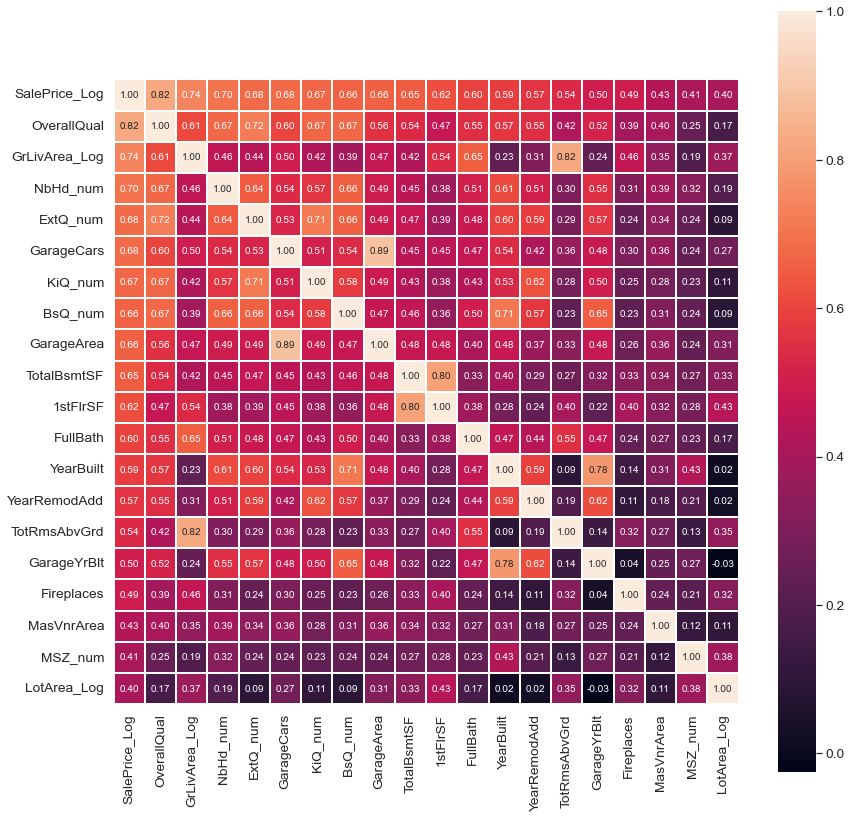

In [ ]:
nr_feats=len(train.columns)
plot_corr_matrix(train, nr_feats, target)

#### 2.13: Check for Multicollinearity

Of those features we drop the one that has smaller correlation coeffiecient to target...

In [ ]:
cols = corr_abs.nlargest(nr_all_cols, target)[target].index
cols = list(cols)

if drop_similar == 1 :
    for col in ['GarageArea','1stFlrSF','TotRmsAbvGrd','GarageYrBlt'] :
        if col in cols: 
            cols.remove(col)

In [ ]:
cols = list(cols)
print(cols)

['SalePrice_Log', 'OverallQual', 'GrLivArea_Log', 'NbHd_num', 'ExtQ_num', 'GarageCars', 'KiQ_num', 'BsQ_num', 'TotalBsmtSF', 'FullBath', 'YearBuilt', 'YearRemodAdd', 'Fireplaces', 'MasVnrArea', 'MSZ_num', 'LotArea_Log']


In [ ]:
feats = cols.copy()
feats.remove('SalePrice_Log')

print(feats)

['OverallQual', 'GrLivArea_Log', 'NbHd_num', 'ExtQ_num', 'GarageCars', 'KiQ_num', 'BsQ_num', 'TotalBsmtSF', 'FullBath', 'YearBuilt', 'YearRemodAdd', 'Fireplaces', 'MasVnrArea', 'MSZ_num', 'LotArea_Log']


In [ ]:
train_ml = train[feats].copy()
test_ml  = test[feats].copy()

y = train[target]

## Modeling (3.0)

#### 3.1: Standard Scaler

In [ ]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
train_ml_sc = sc.fit_transform(train_ml)
test_ml_sc = sc.transform(test_ml)

In [ ]:
train_ml_sc = pd.DataFrame(train_ml_sc)
train_ml_sc.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.658506,0.539624,0.658963,1.061109,0.313159,0.741127,0.648281,-0.473766,0.793546,1.052959,0.880362,-0.952231,0.521228,0.438861,-0.129585
1,-0.068293,-0.380198,0.658963,-0.689001,0.313159,-0.770150,0.648281,0.504925,0.793546,0.158428,-0.428115,0.605965,-0.574433,0.438861,0.118848
2,0.658506,0.671287,0.658963,1.061109,0.313159,0.741127,0.648281,-0.319490,0.793546,0.986698,0.831900,0.605965,0.331164,0.438861,0.427653
3,0.658506,0.551993,0.658963,-0.689001,1.652119,0.741127,-0.921808,-0.714823,-1.025620,-1.862551,-0.718888,0.605965,-0.574433,0.438861,0.108680
4,1.385305,1.299759,2.162512,1.061109,1.652119,0.741127,0.648281,0.222888,0.793546,0.953567,0.734975,0.605965,1.382104,0.438861,0.889271


#### 3.2: Creating Datasets for ML Algorithms

In [ ]:
X = train_ml.copy()
y = train[target]
X_test = test_ml.copy()

X_sc = train_ml_sc.copy()
y_sc = train[target]
X_test_sc = test_ml_sc.copy()

X.info()
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1458 entries, 0 to 1459
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   OverallQual    1458 non-null   int64  
 1   GrLivArea_Log  1458 non-null   float64
 2   NbHd_num       1458 non-null   int64  
 3   ExtQ_num       1458 non-null   int64  
 4   GarageCars     1458 non-null   int64  
 5   KiQ_num        1458 non-null   int64  
 6   BsQ_num        1458 non-null   int64  
 7   TotalBsmtSF    1458 non-null   int64  
 8   FullBath       1458 non-null   int64  
 9   YearBuilt      1458 non-null   int64  
 10  YearRemodAdd   1458 non-null   int64  
 11  Fireplaces     1458 non-null   int64  
 12  MasVnrArea     1458 non-null   float64
 13  MSZ_num        1458 non-null   int64  
 14  LotArea_Log    1458 non-null   float64
dtypes: float64(3), int64(12)
memory usage: 214.5 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (tota

#### 3.3: Basic Regression & Comparing Results

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold
from sklearn.model_selection import GridSearchCV
score_calc = 'neg_mean_squared_error'

#### 3.3.0: Cross-Validation Modeling

In [ ]:
lin_reg = LinearRegression()
cv = KFold(shuffle=True, random_state=2, n_splits=10)
scores = cross_val_score(lin_reg, X,y,cv = cv, scoring = 'neg_mean_absolute_error')

In [ ]:
print ('%.8f'%scores.mean())

-0.09948479


#### 3.3.1: Linear Regression

In [ ]:
#from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
grid_linear = GridSearchCV(linreg, parameters, cv=nr_cv, verbose=1 , scoring = score_calc)
grid_linear.fit(X, y)

sc_linear = get_best_score(grid_linear)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5, estimator=LinearRegression(),
             param_grid={'copy_X': [True, False],
                         'fit_intercept': [True, False],
                         'normalize': [True, False]},
             scoring='neg_mean_squared_error', verbose=1)

0.13623337683103656
{'copy_X': True, 'fit_intercept': True, 'normalize': False}
LinearRegression()


In [ ]:
linreg_sc = LinearRegression()
parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
grid_linear_sc = GridSearchCV(linreg_sc, parameters, cv=nr_cv, verbose=1 , scoring = score_calc)
grid_linear_sc.fit(X_sc, y)

sc_linear_sc = get_best_score(grid_linear_sc)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5, estimator=LinearRegression(),
             param_grid={'copy_X': [True, False],
                         'fit_intercept': [True, False],
                         'normalize': [True, False]},
             scoring='neg_mean_squared_error', verbose=1)

0.13623337683103734
{'copy_X': True, 'fit_intercept': True, 'normalize': True}
LinearRegression(normalize=True)


In [ ]:
linregr_all = LinearRegression()
#linregr_all.fit(X_train_all, y_train_all)
linregr_all.fit(X, y)
pred_linreg_all = linregr_all.predict(X_test)
pred_linreg_all[pred_linreg_all < 0] = pred_linreg_all.mean()

LinearRegression()

In [ ]:
sub_linreg = pd.DataFrame()
sub_linreg['Id'] = id_test
sub_linreg['SalePrice'] = pred_linreg_all
#sub_linreg.to_csv('linreg.csv',index=False)

#### 3.3.2: Ridge Regression

In [ ]:
from sklearn.linear_model import Ridge

ridge = Ridge()
parameters = {'alpha':[0.001,0.005,0.01,0.1,0.5,1], 'normalize':[True,False], 'tol':[1e-06,5e-06,1e-05,5e-05]}
grid_ridge = GridSearchCV(ridge, parameters, cv=nr_cv, verbose=1, scoring = score_calc)
grid_ridge.fit(X, y)

sc_ridge = get_best_score(grid_ridge)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.001, 0.005, 0.01, 0.1, 0.5, 1],
                         'normalize': [True, False],
                         'tol': [1e-06, 5e-06, 1e-05, 5e-05]},
             scoring='neg_mean_squared_error', verbose=1)

0.13620747796635568
{'alpha': 0.01, 'normalize': True, 'tol': 1e-06}
Ridge(alpha=0.01, normalize=True, tol=1e-06)


In [ ]:
ridge_sc = Ridge()
parameters = {'alpha':[0.001,0.005,0.01,0.1,0.5,1], 'normalize':[True,False], 'tol':[1e-06,5e-06,1e-05,5e-05]}
grid_ridge_sc = GridSearchCV(ridge_sc, parameters, cv=nr_cv, verbose=1, scoring = score_calc)
grid_ridge_sc.fit(X_sc, y)

sc_ridge_sc = get_best_score(grid_ridge_sc)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.001, 0.005, 0.01, 0.1, 0.5, 1],
                         'normalize': [True, False],
                         'tol': [1e-06, 5e-06, 1e-05, 5e-05]},
             scoring='neg_mean_squared_error', verbose=1)

0.13620747796635563
{'alpha': 0.01, 'normalize': True, 'tol': 1e-06}
Ridge(alpha=0.01, normalize=True, tol=1e-06)


In [ ]:
pred_ridge_all = grid_ridge.predict(X_test)

#### 3.3.3: Lasso Regression

In [ ]:
from sklearn.linear_model import Lasso

lasso = Lasso()
parameters = {'alpha':[1e-03,0.01,0.1,0.5,0.8,1], 'normalize':[True,False], 'tol':[1e-06,1e-05,5e-05,1e-04,5e-04,1e-03]}
grid_lasso = GridSearchCV(lasso, parameters, cv=nr_cv, verbose=1, scoring = score_calc)
grid_lasso.fit(X, y)

sc_lasso = get_best_score(grid_lasso)

pred_lasso = grid_lasso.predict(X_test)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 0.5, 0.8, 1],
                         'normalize': [True, False],
                         'tol': [1e-06, 1e-05, 5e-05, 0.0001, 0.0005, 0.001]},
             scoring='neg_mean_squared_error', verbose=1)

0.13645599450257964
{'alpha': 0.001, 'normalize': False, 'tol': 0.0001}
Lasso(alpha=0.001)


#### 3.3.4: Elastic Net

In [ ]:
from sklearn.linear_model import ElasticNet

enet = ElasticNet()
parameters = {'alpha' :[0.1,1.0,10], 'max_iter' :[1000000], 'l1_ratio':[0.04,0.05], 
              'fit_intercept' : [False,True], 'normalize':[True,False], 'tol':[1e-02,1e-03,1e-04]}
grid_enet = GridSearchCV(enet, parameters, cv=nr_cv, verbose=1, scoring = score_calc)
grid_enet.fit(X_sc, y_sc)

sc_enet = get_best_score(grid_enet)

pred_enet = grid_enet.predict(X_test_sc)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(cv=5, estimator=ElasticNet(),
             param_grid={'alpha': [0.1, 1.0, 10],
                         'fit_intercept': [False, True],
                         'l1_ratio': [0.04, 0.05], 'max_iter': [1000000],
                         'normalize': [True, False],
                         'tol': [0.01, 0.001, 0.0001]},
             scoring='neg_mean_squared_error', verbose=1)

0.13718483696852146
{'alpha': 0.1, 'fit_intercept': True, 'l1_ratio': 0.04, 'max_iter': 1000000, 'normalize': False, 'tol': 0.01}
ElasticNet(alpha=0.1, l1_ratio=0.04, max_iter=1000000, tol=0.01)


In [ ]:
#tuning hyper parameter of a base model
#we take Kernel Ridge as the base model, then use grid search to find the best hyper parameters
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
parameters = {'alpha':[0.5,0.6,0.7,0.8,0.9,1],
              'kernel':('linear', 'rbf','polynomial'), 
              'degree':[1,2,3],
              'coef0':[1,1.5,2,2.5]}
KRR = KernelRidge()
grid_search = GridSearchCV(KRR, parameters, cv=5, scoring="neg_mean_squared_error")
grid_search.fit(X_sc, y_sc)  
grid_search.best_params_, grid_search.best_score_  
#best params: {'alpha': 1, 'coef0': 2.5, 'degree': 2, 'kernel': 'polynomial'}

GridSearchCV(cv=5, estimator=KernelRidge(),
             param_grid={'alpha': [0.5, 0.6, 0.7, 0.8, 0.9, 1],
                         'coef0': [1, 1.5, 2, 2.5], 'degree': [1, 2, 3],
                         'kernel': ('linear', 'rbf', 'polynomial')},
             scoring='neg_mean_squared_error')

({'alpha': 1, 'coef0': 2.5, 'degree': 2, 'kernel': 'polynomial'},
 -0.01747193153898709)

#### 3.3.5: Random Forest Regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor

param_grid = {'min_samples_split' : [3,4,6,10], 'n_estimators' : [70,100], 'random_state': [5] }
grid_rf = GridSearchCV(RandomForestRegressor(), param_grid, cv=nr_cv, refit=True, verbose=1, scoring = score_calc)
grid_rf.fit(X, y)

sc_rf = get_best_score(grid_rf)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'min_samples_split': [3, 4, 6, 10],
                         'n_estimators': [70, 100], 'random_state': [5]},
             scoring='neg_mean_squared_error', verbose=1)

0.14660163069701856
{'min_samples_split': 4, 'n_estimators': 100, 'random_state': 5}
RandomForestRegressor(min_samples_split=4, random_state=5)


In [ ]:
pred_rf = grid_rf.predict(X_test)

sub_rf = pd.DataFrame()
sub_rf['Id'] = id_test
sub_rf['SalePrice'] = pred_rf 

if use_logvals == 1:
    sub_rf['SalePrice'] = np.exp(sub_rf['SalePrice']) 

sub_rf.to_csv('rf.csv',index=False)

In [ ]:
sub_rf.head(10)

,Id,SalePrice
0,1461,121404.964212
1,1462,130824.396900
2,1463,183372.764889
3,1464,183944.210608
4,1465,198272.459357
5,1466,182039.290710
6,1467,164671.143500
7,1468,175829.325089
8,1469,180844.256443
9,1470,121240.046457


#### 3.3.6: KNN Regressor

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

param_grid = {'n_neighbors' : [3,4,5,6,7,10,15] ,    
              'weights' : ['uniform','distance'] ,
              'algorithm' : ['ball_tree', 'kd_tree', 'brute']}

grid_knn = GridSearchCV(KNeighborsRegressor(), param_grid, cv=nr_cv, refit=True, verbose=1, scoring = score_calc)
grid_knn.fit(X_sc, y_sc)

sc_knn = get_best_score(grid_knn)

Fitting 5 folds for each of 42 candidates, totalling 210 fits


GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
             param_grid={'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [3, 4, 5, 6, 7, 10, 15],
                         'weights': ['uniform', 'distance']},
             scoring='neg_mean_squared_error', verbose=1)

0.15614699236271534
{'algorithm': 'brute', 'n_neighbors': 5, 'weights': 'distance'}
KNeighborsRegressor(algorithm='brute', weights='distance')


In [ ]:
pred_knn = grid_knn.predict(X_test_sc)

sub_knn = pd.DataFrame()
sub_knn['Id'] = id_test
sub_knn['SalePrice'] = pred_knn

if use_logvals == 1:
    sub_knn['SalePrice'] = np.exp(sub_knn['SalePrice']) 

sub_knn.to_csv('knn.csv',index=False)

In [ ]:
sub_knn.head(10)

,Id,SalePrice
0,1461,105027.859167
1,1462,123681.301052
2,1463,178767.921687
3,1464,194161.534320
4,1465,206225.287770
5,1466,177981.936038
6,1467,179348.288690
7,1468,175306.888377
8,1469,181974.660774
9,1470,119589.632069


#### 3.3.7: SGDRegressor

In [ ]:
from sklearn.linear_model import SGDRegressor

sgd = SGDRegressor()
parameters = {'max_iter' :[10000], 'alpha':[1e-05], 'epsilon':[1e-02], 'fit_intercept' : [True]  }
grid_sgd = GridSearchCV(sgd, parameters, cv=nr_cv, verbose=1, scoring = score_calc)
grid_sgd.fit(X_sc, y_sc)

sc_sgd = get_best_score(grid_sgd)

pred_sgd = grid_sgd.predict(X_test_sc)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=5, estimator=SGDRegressor(),
             param_grid={'alpha': [1e-05], 'epsilon': [0.01],
                         'fit_intercept': [True], 'max_iter': [10000]},
             scoring='neg_mean_squared_error', verbose=1)

0.13637490455053863
{'alpha': 1e-05, 'epsilon': 0.01, 'fit_intercept': True, 'max_iter': 10000}
SGDRegressor(alpha=1e-05, epsilon=0.01, max_iter=10000)


#### 3.3.8: Model Comparison Plot

In [ ]:
list_scores = [sc_linear, sc_ridge, sc_lasso, sc_enet,
               sc_sgd, sc_rf, sc_knn]
list_regressors = ['Linear','Ridge','Lasso','ElaNet','SGD','RF','KNN']

<AxesSubplot:>

Text(0, 0.5, 'RMSE')

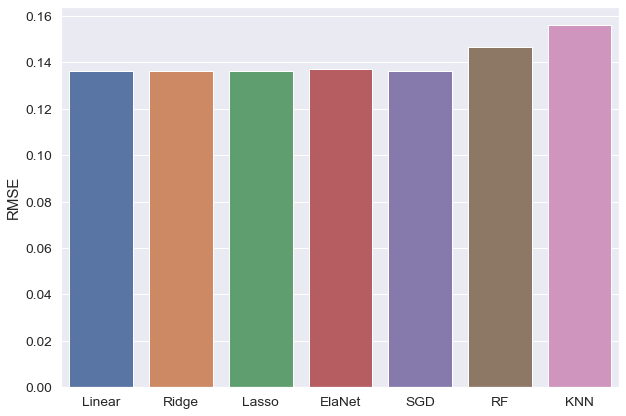

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(10,7)
sns.barplot(x=list_regressors, y=list_scores, ax=ax)
plt.ylabel('RMSE')
plt.show()

The performance of all applied Regressors is very similar, except for KNN which has larger RMSE than the other models.

#### 3.3.9: Correlation of Model Results

In [ ]:
predictions = {'Linear': pred_linreg_all, 'Ridge': pred_ridge_all, 'Lasso': pred_lasso,
               'ElaNet': pred_enet, 'SGD': pred_sgd, 'RF': pred_rf,
               'KNN': pred_knn}
df_predictions = pd.DataFrame(data=predictions) 
df_predictions.corr()

,Linear,Ridge,Lasso,ElaNet,SGD,RF,KNN
Linear,1.000000,0.999988,0.999809,0.999343,0.999747,0.979560,0.964423
Ridge,0.999988,1.000000,0.999835,0.999495,0.999817,0.979501,0.964847
Lasso,0.999809,0.999835,1.000000,0.999543,0.999758,0.979870,0.964510
ElaNet,0.999343,0.999495,0.999543,1.000000,0.999722,0.979243,0.966557
SGD,0.999747,0.999817,0.999758,0.999722,1.000000,0.979426,0.966263
RF,0.979560,0.979501,0.979870,0.979243,0.979426,1.000000,0.962781
KNN,0.964423,0.964847,0.964510,0.966557,0.966263,0.962781,1.000000


<Figure size 504x504 with 0 Axes>

<AxesSubplot:>

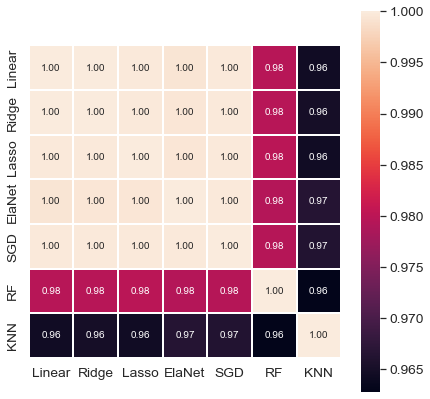

In [ ]:
plt.figure(figsize=(7, 7))
sns.set(font_scale=1.25)
sns.heatmap(df_predictions.corr(), linewidths=1.5, annot=True, square=True, 
                fmt='.2f', annot_kws={'size': 10}, 
                yticklabels=df_predictions.columns , xticklabels=df_predictions.columns
            )
plt.show()

For the first few models, the predictions show a very high correlation to each other (very close to 1.00).
Only for Random Forest and KNN, the results are less correlated with the other Regressors.

## Conclusion (4.0)

As described in the Module 3 Requirements section on Canvas, please reference how I addressed each stated requirement/question below:
- <b>Conduct your analysis using a cross-validation design.</b> Completed above.
- <b>Conduct / improve upon previous EDA</b> Completed above.
- <b>Build models with many variables</b> Completed above.
- <b>Transform and feature engineer as appropriate.</b> Completed above.
- <b>Build Lasso Regression Model.</b> This was addressed in section 3.3.3.  
- <b>Build Ridge Regression Model.</b> This was addressed in section 3.3.2.
- <b>Build ElasticNet Regression Model.</b> This was addressed in section 3.3.4.
- <b>Conduct hyperparameter tuning for the ElasticNet.</b> This was addressed in section 3.3.4.
- <b>Evaluate performance of the model using the Kaggle metric upon which your scores are evaluated.</b> Completed above.
- <b>Submit at least two models to Kaggle.com for evaluation. Provider your Kaggle.com user name and screen snapshots of your Kaggle scores.</b> Seen below.

Below is the screenshot of the Kaggle submission results of the KNN Regressor model

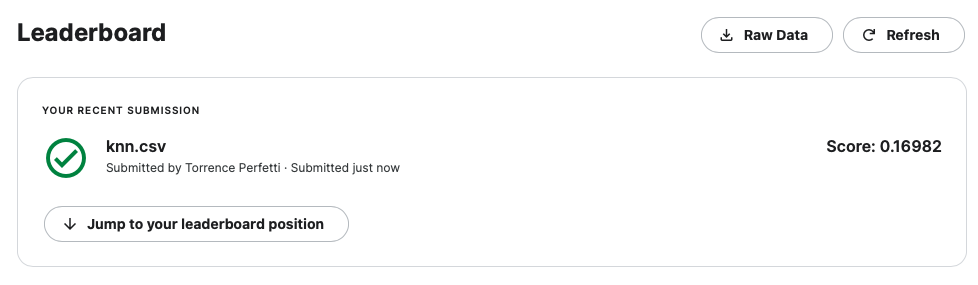

Below is the screenshot of the Kaggle submission results of the Random Forest Regressor model.  The Random Forest model scored better in the competition than the KNN Regressor model.

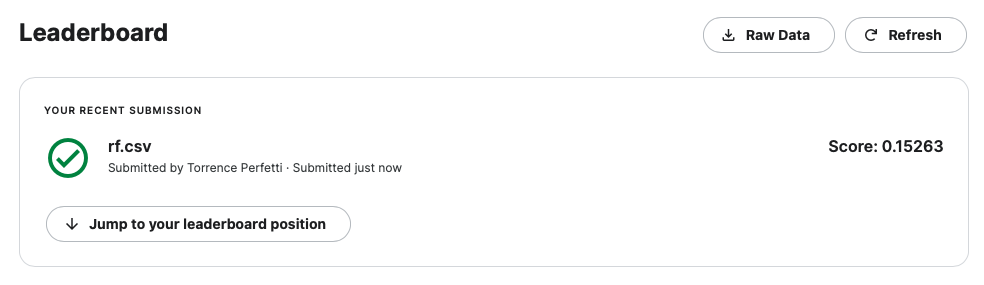